Door open state classification

At first, import packages to be used for the experiments

In [1]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV, PredefinedSplit)
from sklearn.metrics import make_scorer
from scipy.stats import uniform
from joblib import dump, load
from sklearn.base import clone
from sklearn.utils.fixes import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import patches

import numpy as np
from pathlib import Path
import pandas as pd

from pyrcn.echo_state_network import ESNClassifier
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.metrics import accuracy_score, mean_squared_error

from dataset import VideoDoorStateRecognitionDataset
from input_to_node import ClusterInputToNode, SimpleInputToNode
from node_to_node import SCRNodeToNode, DLRBNodeToNode, DLRNodeToNode

In [2]:
sns.set_theme(context="paper")
sns.set(font="Times New Roman")

%matplotlib inline

In [6]:
dataset = VideoDoorStateRecognitionDataset(path=Path(r"./data"))

X, y = dataset.return_X_y()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

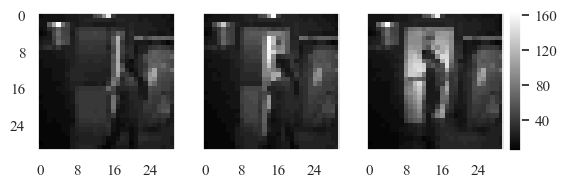

In [5]:
num_row = 1
num_col = 3  # plot images
fig, axes = plt.subplots(num_row, num_col, sharex='all', sharey='all',
                         figsize=(6., 4.))
idx = (1460, 1480, 1560)
for k in range(3):
    ax = axes[k]
    im = ax.imshow(X_train[4][idx[k], :].reshape(30, 30), cmap='gray')
    ax.grid(False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
tick_locator = ticker.MaxNLocator(nbins=5)
cbar_ax = fig.add_axes((.91, 0.32, .02, .35))
cb = fig.colorbar(im, cax=cbar_ax)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('./results/raw_frames.pdf', bbox_inches='tight', pad_inches=0.1)

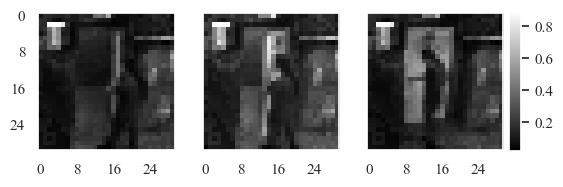

In [6]:
scaler = MinMaxScaler().fit(np.vstack(X_train))
num_row = 1
num_col = 3  # plot images
fig, axes = plt.subplots(num_row, num_col, sharex='all', sharey='all',
                         figsize=(6., 4.))
idx = (1460, 1480, 1560)
for k in range(3):
    ax = axes[k]
    im = ax.imshow(scaler.transform(X_train[4])[idx[k], :].reshape(30, 30),
                   cmap='gray')
    ax.grid(False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
tick_locator = ticker.MaxNLocator(nbins=5)
cbar_ax = fig.add_axes((.91, 0.32, .02, .35))
cb = fig.colorbar(im, cax=cbar_ax)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('./results/normalized_frames.pdf',
            bbox_inches='tight', pad_inches=0.1)

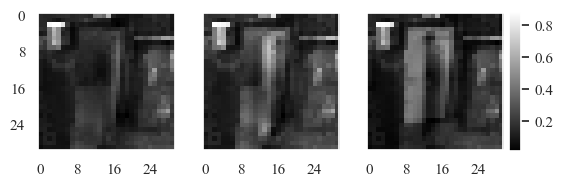

In [7]:
scaler = MinMaxScaler().fit(np.vstack(X_train))
pca = PCA(n_components=30).fit(scaler.transform(np.vstack(X_train)))
num_row = 1
num_col = 3  # plot images
fig, axes = plt.subplots(num_row, num_col, sharex='all', sharey='all',
                         figsize=(6., 4.))
idx = (1460, 1480, 1560)
for k in range(3):
    ax = axes[k]
    x = scaler.transform(X_train[4])
    x = pca.transform(x)
    im = ax.imshow(pca.inverse_transform(x)[idx[k], :].reshape(30, 30),
                   cmap='gray')
    ax.grid(False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
tick_locator = ticker.MaxNLocator(nbins=5)
cbar_ax = fig.add_axes((.91, 0.32, .02, .35))
cb = fig.colorbar(im, cax=cbar_ax)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('./results/inverse_transformed_frames.pdf',
            bbox_inches='tight', pad_inches=0.1)

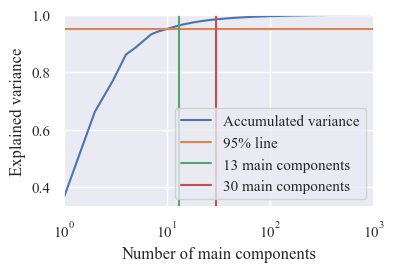

In [8]:
fig, axs = plt.subplots(figsize=(4, 2.5))

sns.lineplot(x=np.arange(900) + 1,
             y=np.cumsum(
                 PCA().fit(np.vstack(X_train)).explained_variance_ratio_),
             ax=axs, label="Accumulated variance")
axs.axhline(y=0.95, label="95% line", c=sns.color_palette()[1])
axs.axvline(x=13, label="13 main components", c=sns.color_palette()[2])
axs.axvline(x=30, label="30 main components", c=sns.color_palette()[3])
axs.set_xlabel("Number of main components")
axs.set_ylabel("Explained variance")
axs.set_xscale("log")
axs.set_xlim(1, 1e3)
axs.set_ylim((None, 1.))
plt.legend()
plt.savefig('./results/pca_analysis.pdf', bbox_inches='tight', pad_inches=0.1)

In [9]:
scaler = MinMaxScaler().fit(np.vstack(X_train))
ohe = OneHotEncoder(sparse_output=False).fit(np.hstack(y).reshape(-1, 1))

y_train_ohe = np.empty_like(y_train)
y_test_ohe = np.empty_like(y_test)

for k in range(len(X_train)):
    X_train[k] = scaler.transform(X_train[k])
    y_train_ohe[k] = ohe.transform(y_train[k].reshape(-1, 1))
for k in range(len(X_test)):
    X_test[k] = scaler.transform(X_test[k])
    y_test_ohe[k] = ohe.transform(y_test[k].reshape(-1, 1))

pca = PCA(n_components=30).fit(np.vstack(X_train))

for k in range(len(X_train)):
    X_train[k] = pca.transform(X_train[k])
for k in range(len(X_test)):
    X_test[k] = pca.transform(X_test[k])

In [10]:
X = np.hstack((X_train, X_test))
y = np.hstack((y_train, y_test))
test_fold = np.zeros(shape=(len(X), ))
test_fold[:len(X_train)] = -1
ps = PredefinedSplit(test_fold=test_fold)

In [11]:
hls_search_params = {'alpha': loguniform(1e-5, 10 - 1e-5)}
hls_search_kwargs = {
    'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': 8, "cv": 3,
    "scoring": make_scorer(mean_squared_error, greater_is_better=False,
                           needs_proba=True)}
final_params = {"random_state": np.arange(10)}
final_kwargs = {"scoring": make_scorer(accuracy_score), "n_jobs": -1,
                "refit": False, "cv": ps, "verbose": 10}
hidden_layer_sizes = (50, 100, 200, 400, 800, 1600, 3200, )

In [12]:
initial_esn_params = {
    'hidden_layer_size': 500, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional': False, 'alpha': 1e-5,
    'random_state': 42}

base_esn = ESNClassifier(**initial_esn_params)
# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(1e-2, 1e0 - 1e-2)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}

searches = [('step1', RandomizedSearchCV, step1_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
            ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'./results/sequential_search_basic_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(
        X_train, y_train_ohe)
    dump(search, f'./results/sequential_search_basic_esn.joblib')

In [13]:
search.all_best_params_

{'step1': {'input_scaling': 0.0616817211686077,
  'spectral_radius': 1.062709263136296},
 'step2': {'leakage': 0.14809892204552141},
 'step3': {'bias_scaling': 0.041168988591604894}}

In [14]:
for hidden_layer_size in hidden_layer_sizes:
    try:
        load(f'./results/basic_esn_hls_{hidden_layer_size}.joblib')
    except FileNotFoundError:
        base_esn = clone(search.best_estimator_).set_params(
            hidden_layer_size=hidden_layer_size)
        esn = RandomizedSearchCV(
            estimator=base_esn, param_distributions=hls_search_params,
            **hls_search_kwargs).fit(X_train, y_train_ohe)
        dump(
            esn, f'./results/basic_esn_hls_{hidden_layer_size}.joblib')

In [15]:
for hidden_layer_size in hidden_layer_sizes:
    esn = load(f'./results/basic_esn_hls_{hidden_layer_size}.joblib')
    final_results = GridSearchCV(
        estimator=clone(esn.best_estimator_), param_grid=final_params,
        **final_kwargs).fit(X, y)
    dump(final_results, f'./results/basic_esn_hls_{hidden_layer_size}'
                        f'_final_results.joblib')

In [16]:
initial_esn_params = {
    'hidden_layer_size': 500, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional': False, 'alpha': 1e-5,
    'random_state': 42, 'cluster_algorithm': 'minibatch_kmeans'}

base_esn = ESNClassifier(input_to_node=ClusterInputToNode(),
                         **initial_esn_params)
# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(1e-2, 1e0 - 1e-2)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}

searches = [('step1', RandomizedSearchCV, step1_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
            ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'./results/sequential_search_kmeans_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(
        X_train, y_train_ohe)
    dump(search, f'./results/sequential_search_kmeans_esn.joblib')

In [17]:
search.all_best_params_

{'step1': {'input_scaling': 0.04050024993904943,
  'spectral_radius': 0.07469637749842883},
 'step2': {'leakage': 0.8103133746352965},
 'step3': {'bias_scaling': 1.9398197043239886}}

In [18]:
for hidden_layer_size in hidden_layer_sizes:
    try:
        load(f'./results/kmeans_esn_hls_{hidden_layer_size}.joblib')
    except FileNotFoundError:
        base_esn = clone(search.best_estimator_).set_params(
            hidden_layer_size=hidden_layer_size)
        esn = RandomizedSearchCV(
            estimator=base_esn, param_distributions=hls_search_params,
            **hls_search_kwargs).fit(X_train, y_train_ohe)
        dump(
            esn, f'./results/kmeans_esn_hls_{hidden_layer_size}.joblib')

In [19]:
for hidden_layer_size in hidden_layer_sizes:
    esn = load(f'./results/kmeans_esn_hls_{hidden_layer_size}.joblib')
    final_results = GridSearchCV(
        estimator=clone(esn.best_estimator_), param_grid=final_params,
        **final_kwargs).fit(X, y)
    dump(final_results, f'./results/kmeans_esn_hls_{hidden_layer_size}'
                        f'_final_results.joblib')

In [20]:
initial_esn_params = {
    'hidden_layer_size': 500, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0, 'forward_weight': 0.0,
    'leakage': 1.0, 'k_rec': 10, 'reservoir_activation': 'tanh',
    'bidirectional': False, 'alpha': 1e-5, 'random_state': 42}

base_esn = ESNClassifier(input_to_node=SimpleInputToNode(),
                         node_to_node=SCRNodeToNode(),
                         **initial_esn_params)
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'forward_weight': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(1e-2, 1e0 - 1e-2)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'./results/sequential_search_scr_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(
        X_train, y_train_ohe)
    dump(search, f'./results/sequential_search_scr_esn.joblib')

In [21]:
search.all_best_params_

{'step1': {'forward_weight': 0.9483476581746504,
  'input_scaling': 0.10783416065100147},
 'step2': {'leakage': 0.7873242017790835},
 'step3': {'bias_scaling': 0.041168988591604894}}

In [22]:
for hidden_layer_size in hidden_layer_sizes:
    try:
        load(f'./results/scr_esn_hls_{hidden_layer_size}.joblib')
    except FileNotFoundError:
        base_esn = clone(search.best_estimator_).set_params(
            hidden_layer_size=hidden_layer_size)
        esn = RandomizedSearchCV(
            estimator=base_esn, param_distributions=hls_search_params,
            **hls_search_kwargs).fit(X_train, y_train_ohe)
        dump(
            esn, f'./results/scr_esn_hls_{hidden_layer_size}.joblib')

In [23]:
for hidden_layer_size in hidden_layer_sizes:
    esn = load(f'./results/scr_esn_hls_{hidden_layer_size}.joblib')
    final_results = GridSearchCV(
        estimator=clone(esn.best_estimator_), param_grid=final_params,
        **final_kwargs).fit(X, y)
    dump(final_results, f'./results/scr_esn_hls_{hidden_layer_size}'
                        f'_final_results.joblib')

In [24]:
initial_esn_params = {
    'hidden_layer_size': 500, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0, 'forward_weight': 0.0,
    'leakage': 1.0, 'k_rec': 10, 'reservoir_activation': 'tanh',
    'bidirectional': False, 'alpha': 1e-5, 'random_state': 42}

base_esn = ESNClassifier(input_to_node=SimpleInputToNode(),
                         node_to_node=DLRNodeToNode(),
                         **initial_esn_params)
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'forward_weight': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(1e-2, 1e0 - 1e-2)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'./results/sequential_search_dlr_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(
        X_train, y_train_ohe)
    dump(search, f'./results/sequential_search_dlr_esn.joblib')

In [25]:
search.all_best_params_

{'step1': {'forward_weight': 0.9483476581746504,
  'input_scaling': 0.10783416065100147},
 'step2': {'leakage': 0.7873242017790835},
 'step3': {'bias_scaling': 0.041168988591604894}}

In [26]:
for hidden_layer_size in hidden_layer_sizes:
    try:
        load(f'./results/dlr_esn_hls_{hidden_layer_size}.joblib')
    except FileNotFoundError:
        base_esn = clone(search.best_estimator_).set_params(
            hidden_layer_size=hidden_layer_size)
        esn = RandomizedSearchCV(
            estimator=base_esn, param_distributions=hls_search_params,
            **hls_search_kwargs).fit(X_train, y_train_ohe)
        dump(
            esn, f'./results/dlr_esn_hls_{hidden_layer_size}.joblib')

In [27]:
for hidden_layer_size in hidden_layer_sizes:
    esn = load(f'./results/dlr_esn_hls_{hidden_layer_size}.joblib')
    final_results = GridSearchCV(
        estimator=clone(esn.best_estimator_), param_grid=final_params,
        **final_kwargs).fit(X, y)
    dump(final_results, f'./results/dlr_esn_hls_{hidden_layer_size}'
                        f'_final_results.joblib')

In [28]:
initial_esn_params = {
    'hidden_layer_size': 500, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0, 'forward_weight': 0.0,
    'feedback_weight': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional':  False, 'alpha': 1e-5,
    'random_state': 42}


base_esn = ESNClassifier(input_to_node=SimpleInputToNode(),
                         node_to_node=DLRBNodeToNode(),
                         **initial_esn_params)
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1)}
step2_params = {'forward_weight': uniform(loc=0, scale=2),
                'feedback_weight': uniform(loc=0, scale=2)}
step3_params = {'leakage': uniform(1e-2, 1e0 - 1e-2)}
step4_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step2 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                'n_jobs': -1, "cv": 3,
                "scoring": make_scorer(mean_squared_error,
                                       greater_is_better=False,
                                       needs_proba=True)}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3),
    ('step4', RandomizedSearchCV, step4_params, kwargs_step4)]

try:
    search = load(f'./results/sequential_search_dlrb_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(
        X_train, y_train_ohe)
    dump(search, f'./results/sequential_search_dlrb_esn.joblib')

In [29]:
search.all_best_params_

{'step1': {'input_scaling': 0.2687799816000169},
 'step2': {'feedback_weight': 0.6092275383467414,
  'forward_weight': 0.19534422801276774},
 'step3': {'leakage': 0.9702107536403743},
 'step4': {'bias_scaling': 0.041168988591604894}}

In [30]:
for hidden_layer_size in hidden_layer_sizes:
    try:
        load(f'./results/dlrb_esn_hls_{hidden_layer_size}.joblib')
    except FileNotFoundError:
        base_esn = clone(search.best_estimator_).set_params(
            hidden_layer_size=hidden_layer_size)
        esn = RandomizedSearchCV(
            estimator=base_esn, param_distributions=hls_search_params,
            **hls_search_kwargs).fit(X_train, y_train_ohe)
        dump(
            esn, f'./results/dlrb_esn_hls_{hidden_layer_size}.joblib')

In [31]:
for hidden_layer_size in hidden_layer_sizes:
    esn = load(f'./results/dlrb_esn_hls_{hidden_layer_size}.joblib')
    final_results = GridSearchCV(
        estimator=clone(esn.best_estimator_), param_grid=final_params,
        **final_kwargs).fit(X, y)
    dump(final_results, f'./results/dlrb_esn_hls_{hidden_layer_size}'
                        f'_final_results.joblib')

In [32]:
df = ([pd.DataFrame(load(f"./results/basic_esn_hls_{hls}_final_results.joblib").cv_results_) for hls in hidden_layer_sizes] + 
      [pd.DataFrame(load(f"./results/dlr_esn_hls_{hls}_final_results.joblib").cv_results_) for hls in hidden_layer_sizes] + 
      [pd.DataFrame(load(f"./results/dlrb_esn_hls_{hls}_final_results.joblib").cv_results_) for hls in hidden_layer_sizes] + 
      [pd.DataFrame(load(f"./results/scr_esn_hls_{hls}_final_results.joblib").cv_results_) for hls in hidden_layer_sizes] + 
      [pd.DataFrame(load(f"./results/kmeans_esn_hls_{hls}_final_results.joblib").cv_results_) for hls in hidden_layer_sizes]
     )

In [33]:
df = pd.concat(df, ignore_index=True)

In [34]:
df["mean_test_score"] = 1 - df["mean_test_score"]
df["Hidden layer size"] = ([50] * 10 + [100] * 10 + [200] * 10 + [400] * 10 + [800] * 10 + [1600] * 10 + [3200] * 10) * 5
df["Architecture"] = (["Basic ESN"] * 70 + ["DLR ESN"] * 70 + ["DLRB ESN"] * 70 + ["SCR ESN"] * 70 + ["KM-ESN"] * 70)

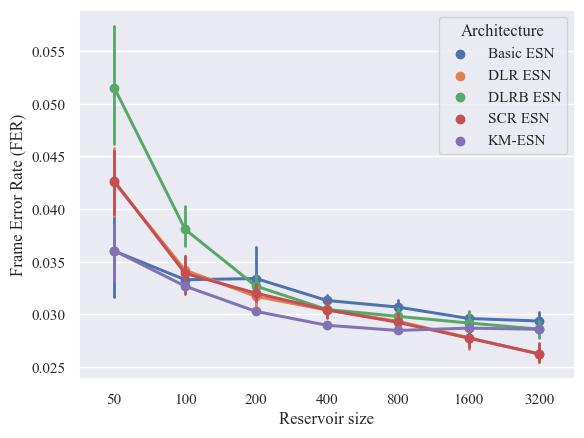

In [35]:
fig, axs = plt.subplots()

sns.pointplot(data=df, x="Hidden layer size", y="mean_test_score", hue="Architecture", scale=.8, errwidth=2, ax=axs)
axs.set_xlabel("Reservoir size")
axs.set_ylabel("Frame Error Rate (FER)")
plt.savefig('./results/video_fer_test_esn.pdf', bbox_inches='tight', pad_inches=0.1)

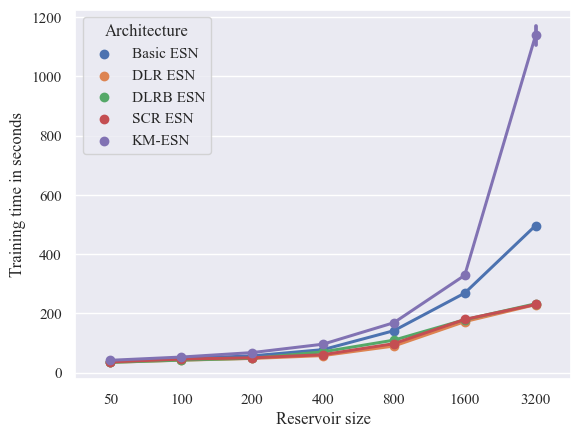

In [36]:
fig, axs = plt.subplots()

sns.pointplot(data=df, x="Hidden layer size", y="mean_fit_time", hue="Architecture", scale=.8, ax=axs)
axs.set_xlabel("Reservoir size")
axs.set_ylabel("Training time in seconds")
plt.savefig('./results/training_times_esn.pdf', bbox_inches='tight', pad_inches=0.1)

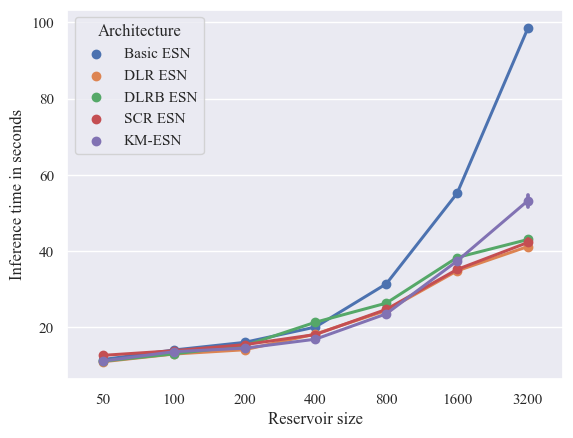

In [37]:
fig, axs = plt.subplots()

sns.pointplot(data=df, x="Hidden layer size", y="mean_score_time", hue="Architecture", scale=.8, ax=axs)
axs.set_xlabel("Reservoir size")
axs.set_ylabel("Inference time in seconds")
plt.savefig('./results/inference_times_esn.pdf', bbox_inches='tight', pad_inches=0.1)

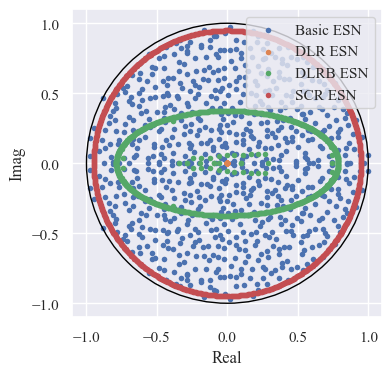

In [38]:
fig, axs = plt.subplots(figsize=(4, 4))

w_rec = load(f'./results/basic_esn_hls_800.joblib').best_estimator_.node_to_node.recurrent_weights.toarray()
w, v = np.linalg.eig(w_rec)
sns.scatterplot(x=w.real, y=w.imag, ax=axs, label="Basic ESN", s=16, linewidth=0)

w_rec = load(f'./results/dlr_esn_hls_800.joblib').best_estimator_.node_to_node.recurrent_weights.toarray()
w, v = np.linalg.eig(w_rec)
sns.scatterplot(x=w.real, y=w.imag, ax=axs, label="DLR ESN", s=16, linewidth=0)

w_rec = load(f'./results/dlrb_esn_hls_800.joblib').best_estimator_.node_to_node.recurrent_weights.toarray()
w, v = np.linalg.eig(w_rec)
sns.scatterplot(x=w.real, y=w.imag, ax=axs, label="DLRB ESN", s=16, linewidth=0)

w_rec = load(f'./results/scr_esn_hls_800.joblib').best_estimator_.node_to_node.recurrent_weights.toarray()
w, v = np.linalg.eig(w_rec)
sns.scatterplot(x=w.real, y=w.imag, ax=axs, label="SCR ESN", s=16, linewidth=0)

axs.set_xlabel("Real")
axs.set_ylabel("Imag")
circle = patches.Circle((0, 0), 1, edgecolor="black", fill=False)
axs.add_patch(circle)
axs.set_xlim((-1.1, 1.1))
axs.set_ylim((-1.1, 1.1))
axs.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
axs.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
plt.savefig('./results/deterministic_esn_eigenvalues.pdf', bbox_inches='tight', pad_inches=0.1)